In [ ]:
# facteurs associés à la scolarisation des filles en Afrique centrale

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os


# Paramètres généraux


dossier_data = "../data"
dossier_out = "../figures"
os.makedirs(dossier_out, exist_ok=True)

pays_codes = ["BDI", "CMR", "CAF", "TCD", "COG", "COD", "GNQ", "GAB", "RWA", "STP"]

pays_noms = {
    "BDI": "Burundi",
    "CMR": "Cameroun",
    "CAF": "Centrafrique",
    "TCD": "Tchad",
    "COG": "Congo",
    "COD": "RD Congo",
    "GNQ": "Guinee eq.",
    "GAB": "Gabon",
    "RWA": "Rwanda",
    "STP": "Sao Tome"
}

In [3]:
# Fonction de chargement UNESCO (même que Work 1)


def charger_unesco(nom_dossier):
    chemin = os.path.join(dossier_data, nom_dossier, "data.csv")
    df = pd.read_csv(chemin)
    df = df[df["geoUnit"].isin(pays_codes)]
    # Période légèrement réduite pour avoir plus de données Banque Mondiale
    df = df[(df["year"] >= 2008) & (df["year"] <= 2024)]
    df["pays"] = df["geoUnit"].map(pays_noms)
    return df



# Chargement des données Banque Mondiale


chemin_wb = os.path.join(
    dossier_data,
    "P_Data_Extract_From_World_Development_Indicators",
    "data.csv"
)

wb = pd.read_csv(chemin_wb)

# Colonnes qui contiennent les données annuelles (format "2008 [YR2008]")
cols_annees = [
    '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]',
    '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]',
    '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]',
    '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]',
    '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]',
    '2023 [YR2023]', '2024 [YR2024]'
]

# On transforme le tableau large en tableau long (une ligne = un pays, une année, un indicateur)
wb_long = pd.melt(
    wb,
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=cols_annees,
    var_name="annee_raw",
    value_name="value"
)

# Extraction de l'année depuis la colonne brute
wb_long["year"] = wb_long["annee_raw"].str[:4].astype(int)

# Remplacement des valeurs manquantes ".." par NaN
wb_long["value"] = wb_long["value"].replace("..", np.nan)
wb_long["value"] = pd.to_numeric(wb_long["value"], errors="coerce")

# On garde uniquement nos 10 pays
wb_long = wb_long[wb_long["Country Code"].isin(pays_codes)]
wb_long = wb_long.dropna(subset=["value"])

print("Nombre d'observations Banque Mondiale :", len(wb_long))


Nombre d'observations Banque Mondiale : 2300


In [4]:
# Extraction des variables d'intérêt (une par série)


# PIB par habitant en parité de pouvoir d'achat (en dollars courants)
gdp = wb_long[wb_long["Series Code"] == "NY.GDP.PCAP.PP.CD"].copy()
gdp = gdp[["Country Code", "year", "value"]]
gdp.columns = ["pays_code", "year", "gdp_pc"]

# Part de la population rurale (%)
rural = wb_long[wb_long["Series Code"] == "SP.RUR.TOTL.ZS"].copy()
rural = rural[["Country Code", "year", "value"]]
rural.columns = ["pays_code", "year", "rural_pct"]

# Taux de fécondité adolescente (naissances pour 1000 femmes de 15-19 ans)
fecondite = wb_long[wb_long["Series Code"] == "SP.ADO.TFRT"].copy()
fecondite = fecondite[["Country Code", "year", "value"]]
fecondite.columns = ["pays_code", "year", "fecondite_ado"]

# Dépenses publiques d'éducation (% du PIB)
depenses = wb_long[wb_long["Series Code"] == "SE.XPD.TOTL.GD.ZS"].copy()
depenses = depenses[["Country Code", "year", "value"]]
depenses.columns = ["pays_code", "year", "depenses_educ"]

# Taux de croissance de la population (%)
croissance = wb_long[wb_long["Series Code"] == "SP.POP.GROW"].copy()
croissance = croissance[["Country Code", "year", "value"]]
croissance.columns = ["pays_code", "year", "croissance_pop"]

print("PIB :", len(gdp), "observations")
print("Rural :", len(rural), "observations")
print("Fécondité :", len(fecondite), "observations")
print("Dépenses educ :", len(depenses), "observations")
print("Croissance pop :", len(croissance), "observations")

PIB : 170 observations
Rural : 170 observations
Fécondité : 160 observations
Dépenses educ : 130 observations
Croissance pop : 170 observations


In [5]:
# Construction du tableau panel
# (une ligne = un pays, une année)


# On part du PIB comme base et on joint les autres variables
panel = gdp.copy()
panel = pd.merge(panel, rural,      on=["pays_code", "year"], how="left")
panel = pd.merge(panel, fecondite,  on=["pays_code", "year"], how="left")
panel = pd.merge(panel, depenses,   on=["pays_code", "year"], how="left")
panel = pd.merge(panel, croissance, on=["pays_code", "year"], how="left")

# On prend le log du PIB (relation non-linéaire entre PIB et éducation)
panel["log_gdp"] = np.log(panel["gdp_pc"])

# Ajout du nom lisible du pays
panel["pays"] = panel["pays_code"].map(pays_noms)

print("Taille du panel :", len(panel), "observations")

Taille du panel : 170 observations


In [6]:
# Ajout de la variable cible : taux d'achèvement
# secondaire supérieur pour les filles (CR.MOD.3.F)


completion = charger_unesco("indicator-data-export_CR.MOD.1.F_CR.MOD.1.M_CR.MOD.2.F_and_3_more")

# On garde uniquement l'achèvement secondaire supérieur - filles
comp_filles = completion[completion["indicatorId"] == "CR.MOD.3.F"].copy()
comp_filles = comp_filles[["geoUnit", "year", "value"]]
comp_filles.columns = ["pays_code", "year", "completion_filles"]

# Fusion avec le panel économique
panel = pd.merge(panel, comp_filles, on=["pays_code", "year"], how="inner")

# On supprime les lignes avec des valeurs manquantes
panel_propre = panel.dropna()

print("Panel final :", len(panel_propre), "observations")
print("Pays présents :", panel_propre["pays"].unique())


Panel final : 129 observations
Pays présents : ['Burundi' 'Cameroun' 'Centrafrique' 'Rwanda' 'Sao Tome' 'Tchad' 'Congo'
 'RD Congo' 'Gabon']


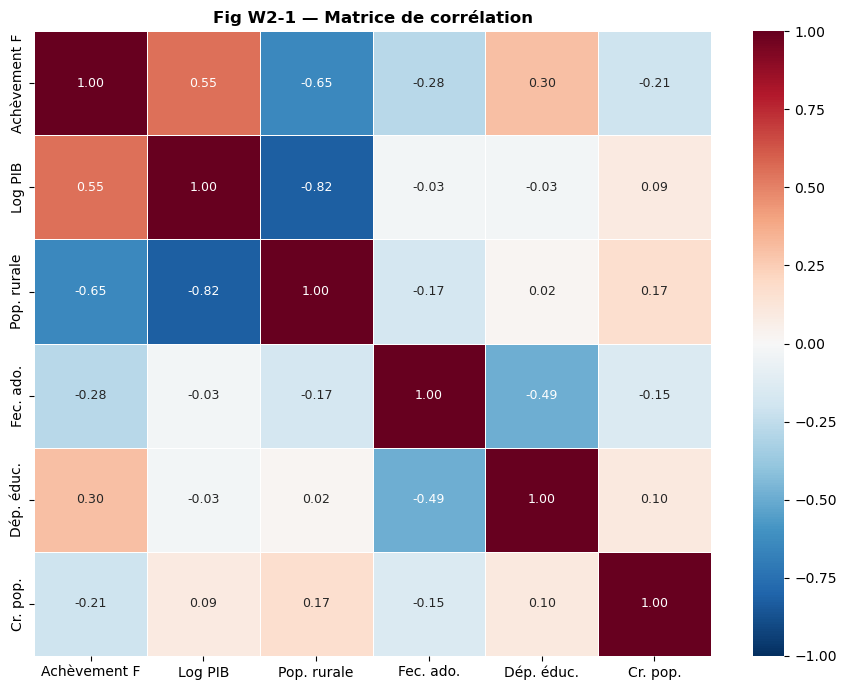

Figure W2-1 sauvegardée


In [7]:
# FIGURE W2-1 : Matrice de corrélation
# C'est notre premier diagnostic : quelles variables
# sont liées au taux d'achèvement des filles ?


# Variables à analyser
vars_corr = [
    "completion_filles",
    "log_gdp",
    "rural_pct",
    "fecondite_ado",
    "depenses_educ",
    "croissance_pop"
]

# Calcul de la matrice de corrélation de Pearson
mat_corr = panel_propre[vars_corr].corr()

# Noms lisibles pour l'affichage
labels_corr = {
    "completion_filles": "Achèvement F",
    "log_gdp":           "Log PIB",
    "rural_pct":         "Pop. rurale",
    "fecondite_ado":     "Fec. ado.",
    "depenses_educ":     "Dép. éduc.",
    "croissance_pop":    "Cr. pop."
}
mat_corr = mat_corr.rename(index=labels_corr, columns=labels_corr)

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    mat_corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    ax=ax,
    annot_kws={"size": 9}
)
ax.set_title("Fig W2-1 — Matrice de corrélation", fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(dossier_out, "w2_fig1_correlation.png"), dpi=300)
plt.show()
print("Figure W2-1 sauvegardée")

In [8]:
# Régression OLS (Moindres Carrés Ordinaires)
# Variable dépendante : taux d'achèvement filles
# Variables explicatives : économiques et démographiques


# Sélection des variables explicatives
X = panel_propre[[
    "log_gdp",
    "rural_pct",
    "fecondite_ado",
    "depenses_educ",
    "croissance_pop"
]]

# Variable à expliquer
y = panel_propre["completion_filles"]

# Ajout d'une constante (terme alpha dans Y = alpha + beta*X + epsilon)
X_const = sm.add_constant(X)

# Estimation du modèle
modele = sm.OLS(y, X_const)
resultats = modele.fit()

# Affichage des résultats complets
print(resultats.summary())

                            OLS Regression Results                            
Dep. Variable:      completion_filles   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     39.66
Date:                Sun, 22 Feb 2026   Prob (F-statistic):           4.17e-24
Time:                        15:04:54   Log-Likelihood:                -436.46
No. Observations:                 129   AIC:                             884.9
Df Residuals:                     123   BIC:                             902.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.1414     14.818      2.

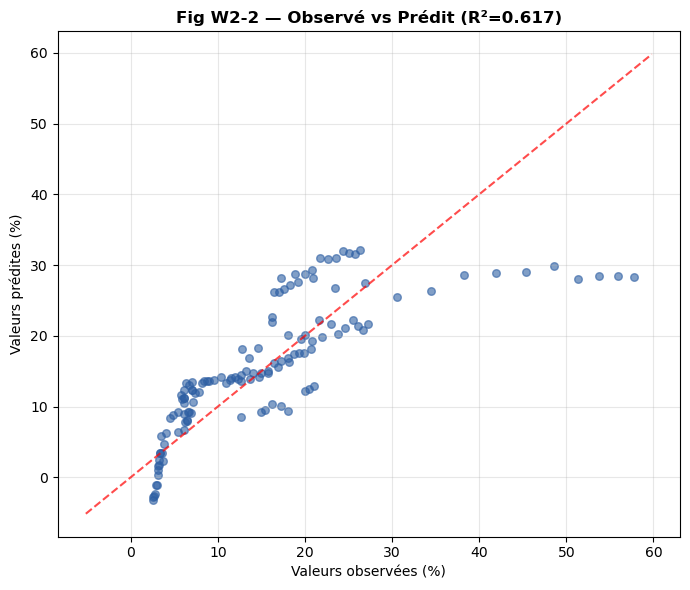

Figure W2-2 sauvegardée


In [9]:
# FIGURE W2-2 : Valeurs observées vs valeurs prédites
# Si les points sont proches de la diagonale, le modèle est bon


y_pred = resultats.fittedvalues

# Calcul du R² pour le titre
r2 = round(resultats.rsquared, 3)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y, y_pred, alpha=0.6, s=30, color="#2E5FA3")

# Ligne diagonale = prédiction parfaite
lim_min = min(y.min(), y_pred.min()) - 2
lim_max = max(y.max(), y_pred.max()) + 2
ax.plot([lim_min, lim_max], [lim_min, lim_max], "r--", alpha=0.7)

ax.set_xlabel("Valeurs observées (%)")
ax.set_ylabel("Valeurs prédites (%)")
ax.set_title("Fig W2-2 — Observé vs Prédit (R²=" + str(r2) + ")", fontweight="bold")
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(dossier_out, "w2_fig2_observe_predit.png"), dpi=300)
plt.show()
print("Figure W2-2 sauvegardée")


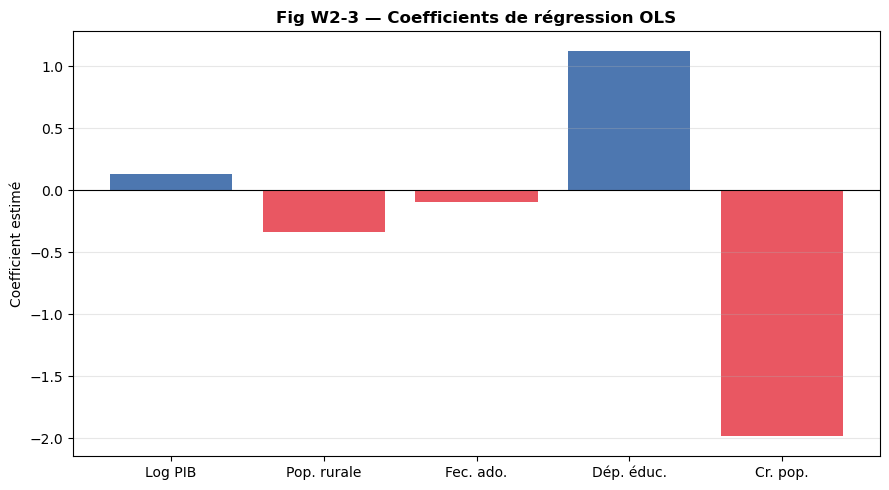

Figure W2-3 sauvegardée


In [10]:
# FIGURE W2-3 : Coefficients de régression
# Un coefficient positif = la variable augmente l'achèvement
# Un coefficient négatif = la variable réduit l'achèvement


# On récupère les coefficients estimés (sans la constante)
variables  = ["log_gdp", "rural_pct", "fecondite_ado", "depenses_educ", "croissance_pop"]
labels     = ["Log PIB", "Pop. rurale", "Fec. ado.", "Dép. éduc.", "Cr. pop."]
coefs      = [resultats.params[v] for v in variables]

# Couleur bleue si positif, rouge si négatif
couleurs = ["#2E5FA3" if c > 0 else "#E63946" for c in coefs]

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(labels, coefs, color=couleurs, alpha=0.85)
ax.axhline(0, color="black", linewidth=0.8)
ax.set_title("Fig W2-3 — Coefficients de régression OLS", fontweight="bold")
ax.set_ylabel("Coefficient estimé")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(dossier_out, "w2_fig3_coefficients.png"), dpi=300)
plt.show()
print("Figure W2-3 sauvegardée")

In [11]:
# Clustering KMeans (K=3 groupes de pays)
# On cherche à regrouper les pays qui se ressemblent
# selon leurs indicateurs économiques et éducatifs


# Variables utilisées pour former les groupes
vars_cluster = [
    "completion_filles",
    "log_gdp",
    "rural_pct",
    "fecondite_ado",
    "depenses_educ"
]

data_cluster = panel_propre[vars_cluster].copy()

# Standardisation obligatoire : sinon le PIB dominerait les autres variables
scaler = StandardScaler()
data_normalisee = scaler.fit_transform(data_cluster)

# Application de KMeans avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(data_normalisee)

# Ajout du numéro de cluster au tableau
panel_propre = panel_propre.copy()
panel_propre["cluster"] = kmeans.labels_

# Affichage des pays dans chaque groupe
print("\nComposition des clusters :")
for cl in sorted(panel_propre["cluster"].unique()):
    pays_dans_cluster = panel_propre[panel_propre["cluster"] == cl]["pays"].unique()
    print("Cluster", cl, ":", pays_dans_cluster)


Composition des clusters :
Cluster 0 : ['Sao Tome' 'Congo' 'Gabon' 'Cameroun']
Cluster 1 : ['Burundi' 'Rwanda']
Cluster 2 : ['Cameroun' 'Centrafrique' 'Tchad' 'RD Congo']


C:\Users\reill\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [12]:
# ACP (Analyse en Composantes Principales)
# On réduit les 5 variables à 2 axes pour pouvoir visualiser


pca = PCA(n_components=2)
coords = pca.fit_transform(data_normalisee)

# Part de variance expliquée par chaque axe
variance_pc1 = round(pca.explained_variance_ratio_[0] * 100, 1)
variance_pc2 = round(pca.explained_variance_ratio_[1] * 100, 1)

# Ajout des coordonnées au tableau
panel_propre["PC1"] = coords[:, 0]
panel_propre["PC2"] = coords[:, 1]

print("\nVariance expliquée par les 2 axes :", variance_pc1 + variance_pc2, "%")



Variance expliquée par les 2 axes : 79.6 %


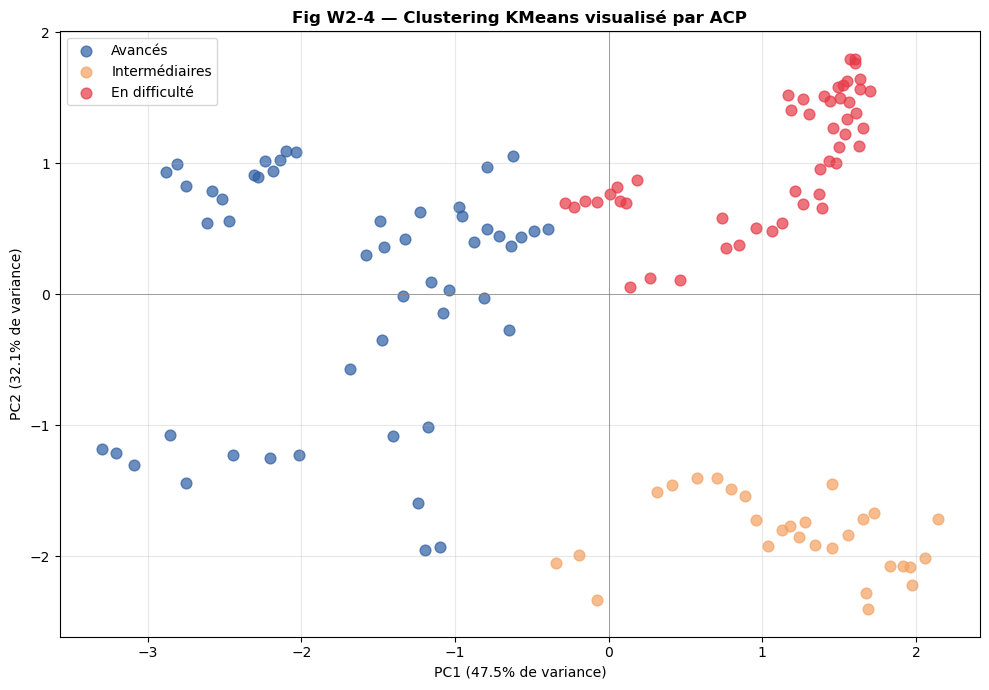

Figure W2-4 sauvegardée

Work 2 terminé — 4 figures sauvegardées dans ../figures


In [13]:
# FIGURE W2-4 : Visualisation des clusters sur le plan ACP


couleurs_cl  = {0: "#2E5FA3", 1: "#F4A261", 2: "#E63946"}
noms_clusters = {0: "Avancés", 1: "Intermédiaires", 2: "En difficulté"}

fig, ax = plt.subplots(figsize=(10, 7))

for cl in sorted(panel_propre["cluster"].unique()):
    data_cl = panel_propre[panel_propre["cluster"] == cl]
    ax.scatter(
        data_cl["PC1"],
        data_cl["PC2"],
        color=couleurs_cl[cl],
        label=noms_clusters[cl],
        s=60,
        alpha=0.7
    )

ax.set_xlabel("PC1 (" + str(variance_pc1) + "% de variance)")
ax.set_ylabel("PC2 (" + str(variance_pc2) + "% de variance)")
ax.set_title("Fig W2-4 — Clustering KMeans visualisé par ACP", fontweight="bold")
ax.axhline(0, color="grey", linewidth=0.5)
ax.axvline(0, color="grey", linewidth=0.5)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(dossier_out, "w2_fig4_clusters_pca.png"), dpi=300)
plt.show()
print("Figure W2-4 sauvegardée")

print("\nWork 2 terminé — 4 figures sauvegardées dans", dossier_out)
